In [1]:
print("Alive")

Alive


In [2]:
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

import isthmuslib
import matplotlib.pyplot as plt
import pandas as pd
import itertools

## Load the data

In [3]:
data_path = Path.cwd() / "output" / "rs16_era_1679780030.csv"
if not data_path.exists():
    raise FileNotFoundError(f"File {data_path} not found")
v: isthmuslib.VectorMultiset = isthmuslib.VectorMultiset().read_csv(data_path, inplace=False)

## Light feature eng

In [4]:
def get_len_extra_str(x: str) -> int:
    return x.count(',') + 1
v.data['len_extra'] = v.data["extra"].apply(get_len_extra_str)
v.data['ratio_len_extra_num_outputs'] = v.data['len_extra'] / v.data['num_outputs']

In [ ]:
v.data.head()["extra"].str.split(",").apply(len)

In [5]:
v.head().transpose()

,0,1,2,3,4
tx_hash,e6ee99891a8380730a0e2f9f5befa61736968f8fff8966...,6469cbb6dc6e04bfc9fe181a21250b4bc52e518d7e4f54...,73d13d799e47c0ede39e34d513bdfca583fbae7e62b4d3...,57a6497d3b3a1d4f69ea8c31898e1390ab0bd4a47922f2...,acecb9fd0e666c480e0d0c5221fd7b840cb1b33afe83f3...
block_height,2688888,2688888,2688888,2688888,2688888
block_timestamp,1660416458,1660416458,1660416458,1660416458,1660416458
version,2,2,2,2,2
unlock_time,0,0,0,0,0
num_inputs,1,1,2,1,1
num_outputs,2,2,2,2,2
extra,"[1, 130, 171, 236, 79, 222, 123, 211, 149, 169...","[1, 53, 72, 66, 223, 51, 96, 88, 235, 200, 167...","[1, 101, 67, 95, 61, 45, 98, 194, 14, 170, 142...","[1, 16, 44, 199, 24, 6, 38, 217, 19, 109, 164,...","[1, 86, 0, 203, 44, 211, 108, 168, 89, 30, 102..."
txn_fee_atomic,5816000000.0,145300000.0,39380000.0,29080000.0,29120000.0
rct_type,5.0,5.0,5.0,5.0,5.0


## Viz

In [6]:
keys: List[str] = [
    # 'version',
    # 'unlock_time',
    # 'num_inputs',
    # 'num_outputs',
    # 'txn_fee_atomic',
    # 'rct_type',
    'len_extra',
    # 'ratio_len_extra_num_outputs',
]

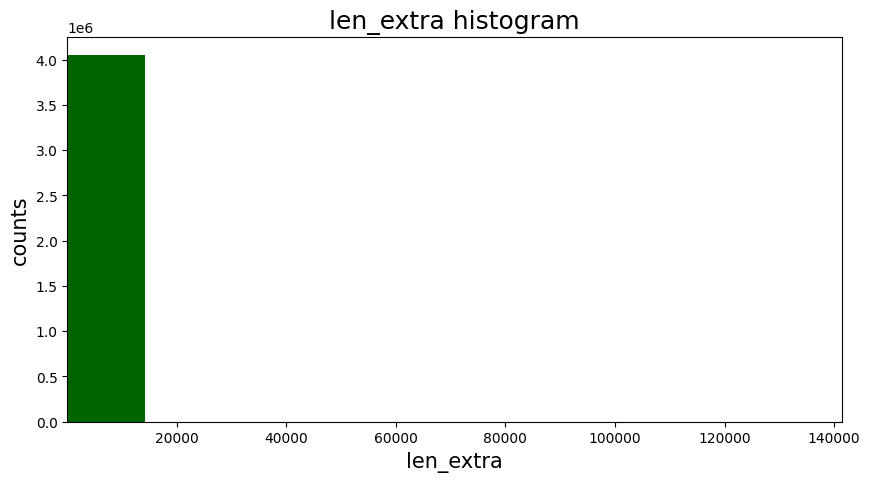

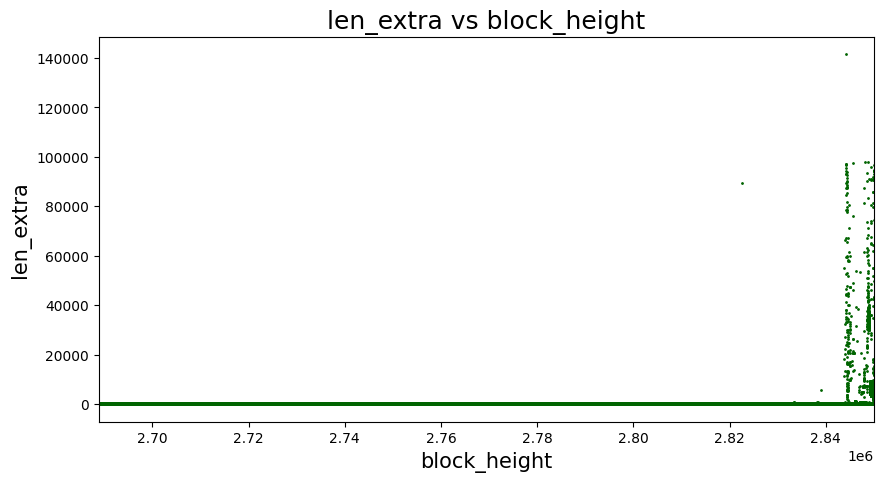

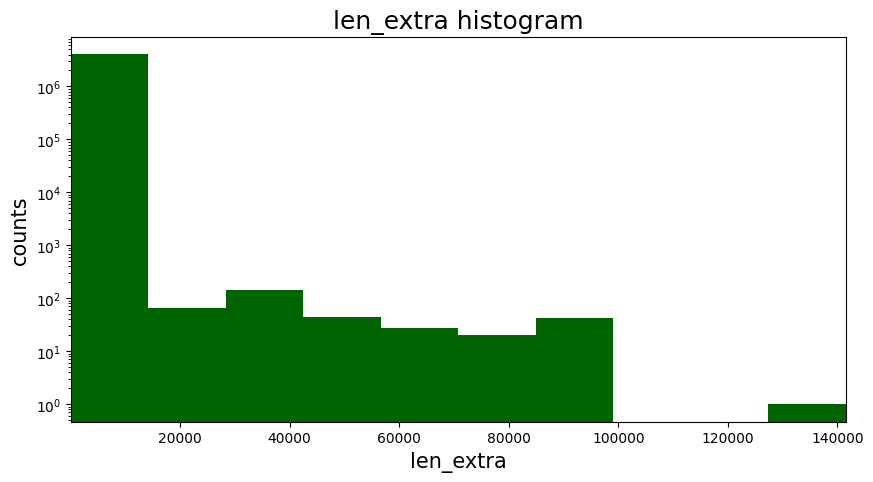

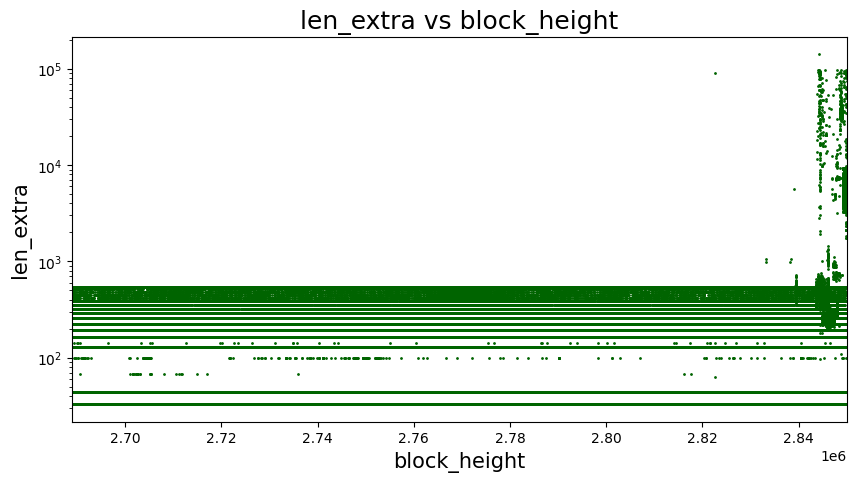

In [7]:
for field_name, log_axes in itertools.product(keys, ['', 'y']):
    plot_kwargs: Dict[str, Any] = {
        'show': True,
        'figsize': (10, 5),
        'log_axes': log_axes,
    }
    v.hist(
        field_name,
        title=f"{field_name} histogram",
        **plot_kwargs
    )
    v.scatter(
        x='block_height',
        y=field_name,
        title=f"{field_name} vs block_height",
        markersize=1,
        **plot_kwargs
    )

## Some frequency analysis

In [8]:
def get_most_frequent_values(
        df: pd.DataFrame,
        col: str = "txn_fee_atomic",
        limit: Optional[int] = 50,
        min_value: Optional[float] = None,
        max_value: Optional[float] = None
) -> pd.DataFrame:
    """
    Get the most frequent values in the specified column of a DataFrame.
    """
    # Filter the DataFrame based on the min_value and max_value
    if min_value is not None:
        df = df[df[col] >= min_value]
    if max_value is not None:
        df = df[df[col] <= max_value]

    # Check if the filtered DataFrame is empty
    if df.empty:
        print("No data found for the specified range.")
        return pd.DataFrame()

    # Calculate the frequency of each value in the specified column
    freq_df = df[col].value_counts().reset_index()
    freq_df.columns = [col, 'frequency']

    # Limit the number of results if specified
    if limit is not None:
        freq_df = freq_df.head(limit)

    # Print the results to the console
    print(freq_df.head().transpose())

    # Return the DataFrame containing the most frequent values and their frequencies
    return freq_df


fdf: pd.DataFrame = get_most_frequent_values(v.data, col='txn_fee_atomic', limit=15, min_value=1e8, max_value=1e9)
fdf.astype(int).head(15)
print(fdf.astype(int)['txn_fee_atomic'].tolist())

                          0            1            2            3  \
txn_fee_atomic  240600000.0  160400000.0  793000000.0  158600000.0   
frequency           82010.0      68937.0      34990.0      30953.0   

                          4  
txn_fee_atomic  122640000.0  
frequency           15203.0  
[240600000, 160400000, 793000000, 158600000, 122640000, 710400000, 122720000, 710080000, 342450000, 710720000, 122560000, 228300000, 709760000, 226500000, 711040000]


In [9]:
def is_in_ymxb_fees(q: int, intercept: int = 31720000000, increment: int = 13580000000) -> bool:
    return (q - intercept) % increment == 0

# Visualize various aspects of v1 logic...

In [10]:
# Count the number of transactions with unlock time < 200
sub_theta: float = len(v.data[v.data['unlock_time'] <= 200])
sub_theta_nonzero: float = len(v.data[(v.data['unlock_time'] <= 200) & (v.data['unlock_time'] > 0)])
print(f"Number of txns with unlock time <= 200: {sub_theta} ({sub_theta / len(v.data) * 100:.4f}%)")
print(f"Num of txns with 0 < unlock time <= 200 : {sub_theta_nonzero} ({sub_theta_nonzero / len(v.data) * 100:.4f}%)")

Number of txns with unlock time <= 200: 4050822 (99.9956%)
Num of txns with 0 < unlock time <= 200 : 1557 (0.0384%)


In [11]:
plot_kwargs: Dict[str, Any] = {
    'show': False,
    'figsize': (10, 5),
}

Set parameters

In [12]:
delay_tolerance_blocks: float = 720
unlock_time_high_cutoff: int = 100_000_000

### Heuristic: Unlock times above 100,000,000 are atypical
(may or may not be present depending on your data)

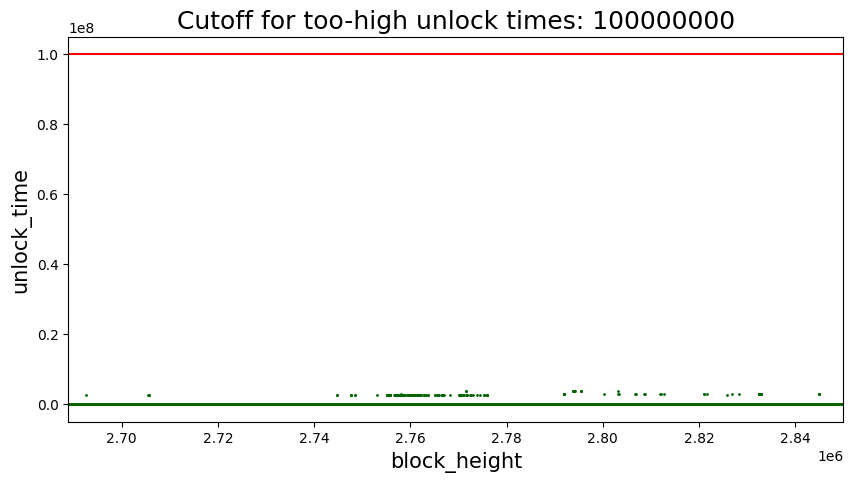

In [13]:
v.scatter(
    x='block_height',
    y='unlock_time',
    title=f"Cutoff for too-high unlock times: {unlock_time_high_cutoff}",
    markersize=1,
    **plot_kwargs
)
plt.axhline(unlock_time_high_cutoff, color='r');

### Heuristic: Unlock times more than 720 blocks under the current block height are atypical
This could mean they were created with a low value or delayed
Note that unlock_time==0 is OK, this is the standard wallet2 behavior if not specified

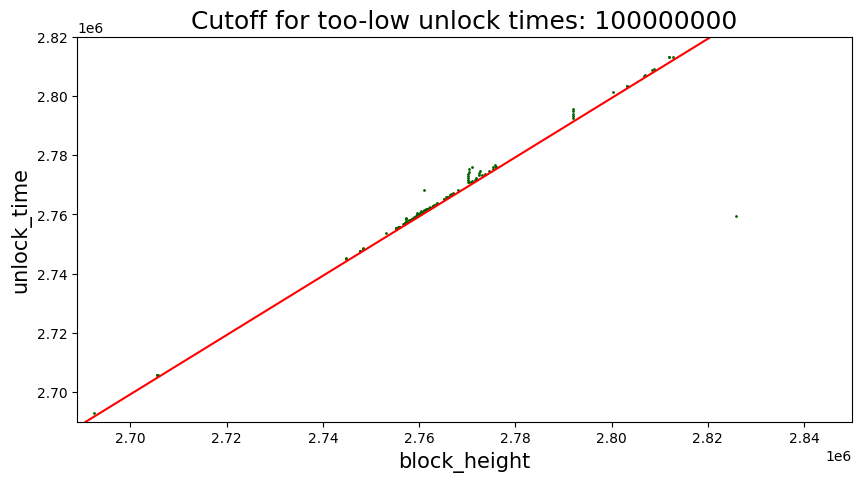

In [14]:
v.scatter(
    x='block_height',
    y='unlock_time',
    title=f"Cutoff for too-low unlock times: {unlock_time_high_cutoff}",
    markersize=1,
    **plot_kwargs,
    ylim=(2.69e6, 2.82e6),
)
plt.plot(
    v.data.block_height.tolist(),
    (v.data.block_height - delay_tolerance_blocks).tolist(),
    color='r'
);

### Fees with an (intercept, increment) generator

In [15]:
def is_from_bkx_generator(q: int, generators: List[Tuple[int, int]] = None) -> bool:
    if generators is None:
        generators = [
            (6124000000, 40000000),
            (31720000000, 13580000000),
            # (122560000, 80000),
            # (158600000, 1800000),
            # (226500000, 1800000),
            # (709760000, 320000)
        ]

    for intercept, increment in generators:
        if (q - intercept) % increment == 0:
            return True
    return False


v.data['is_in_ymxb_fees'] = v.data['txn_fee_atomic'].apply(is_from_bkx_generator)

14084


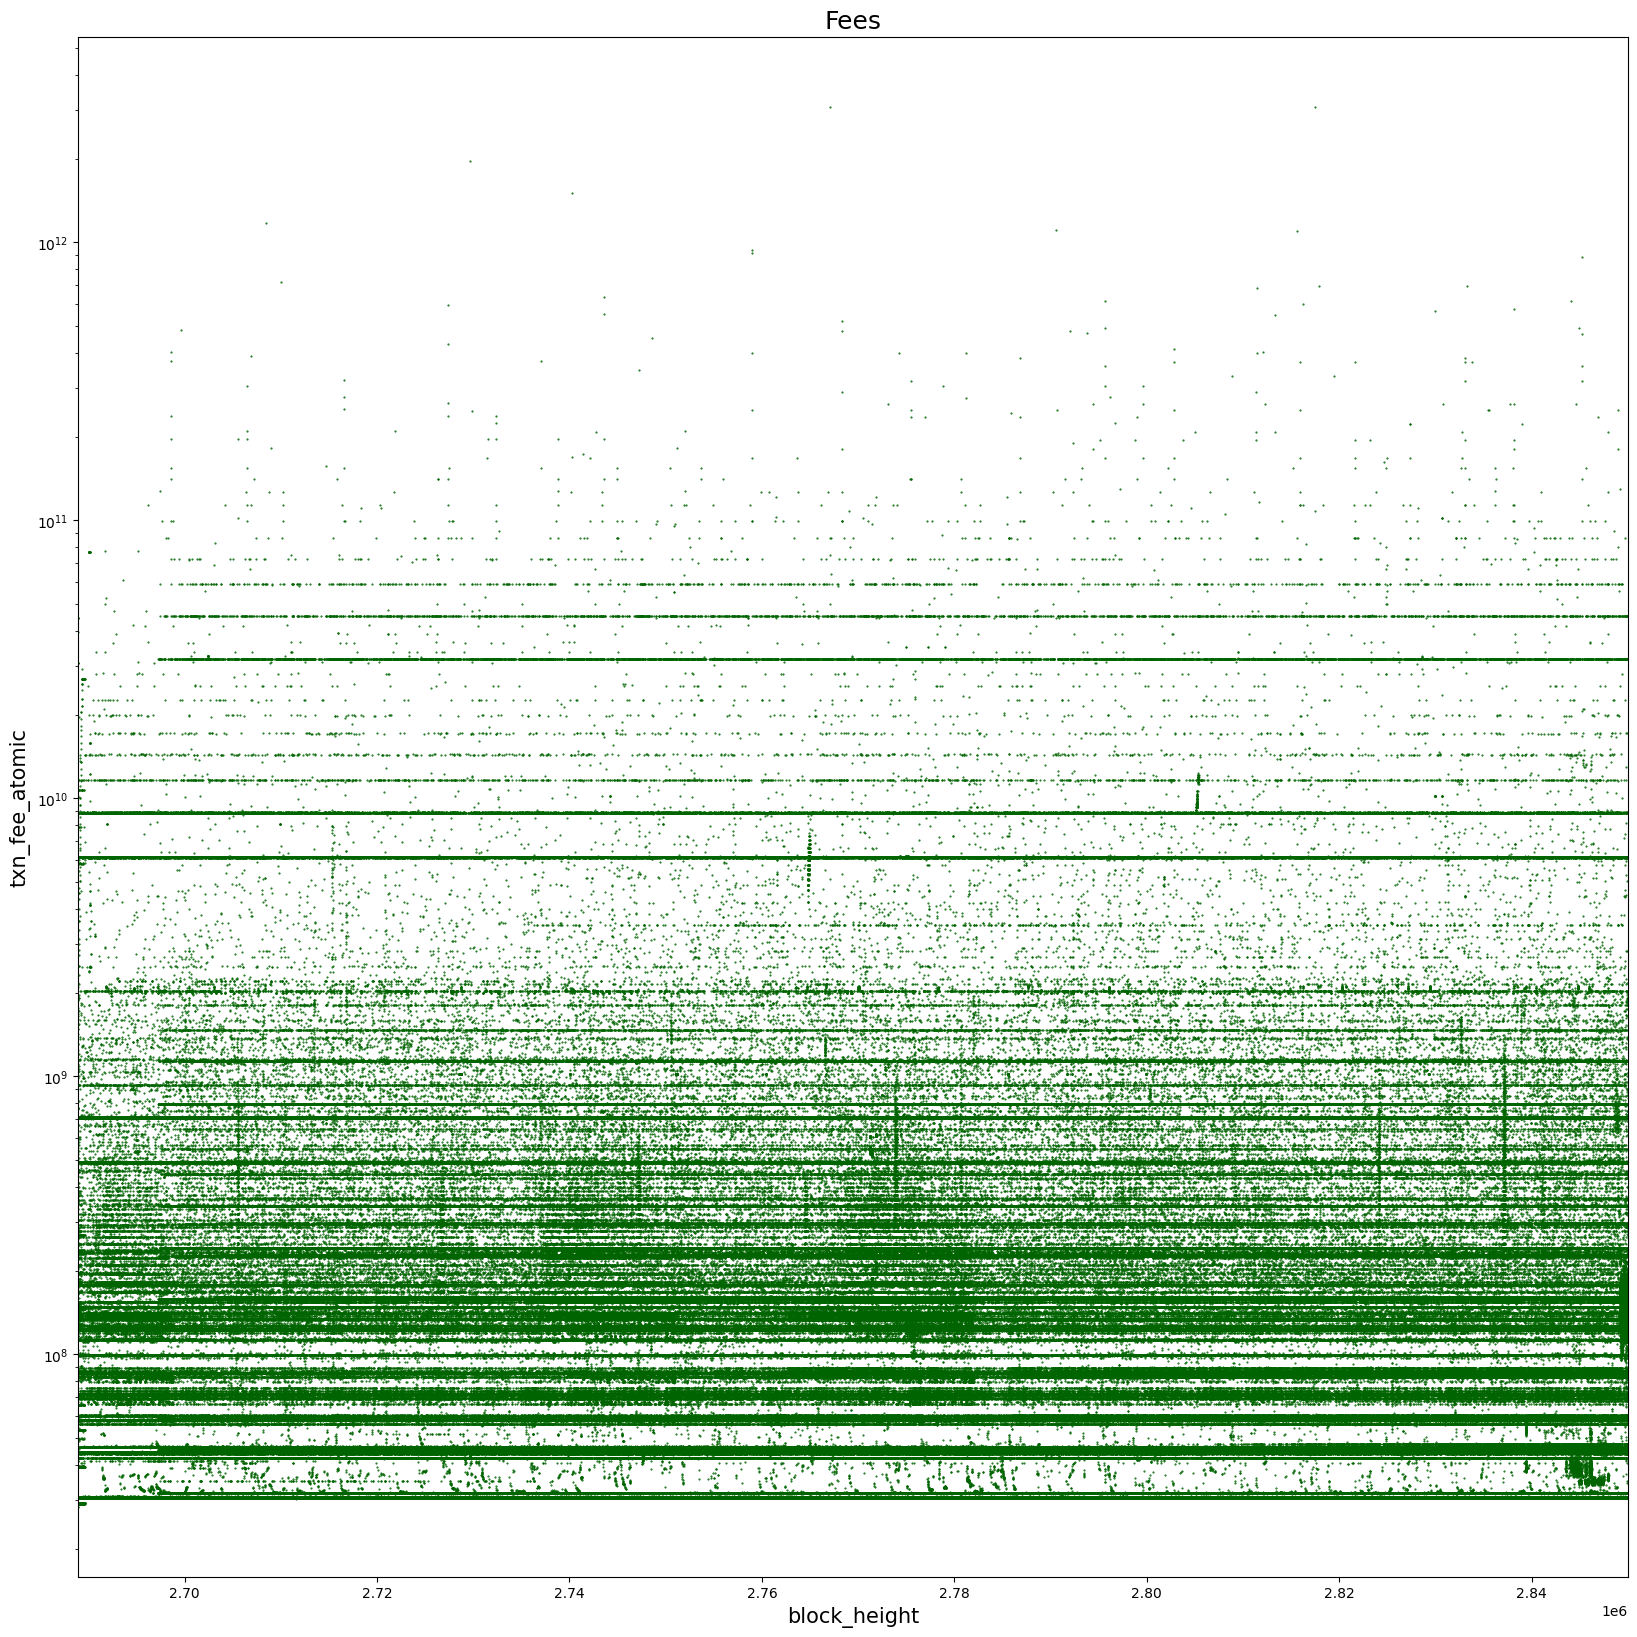

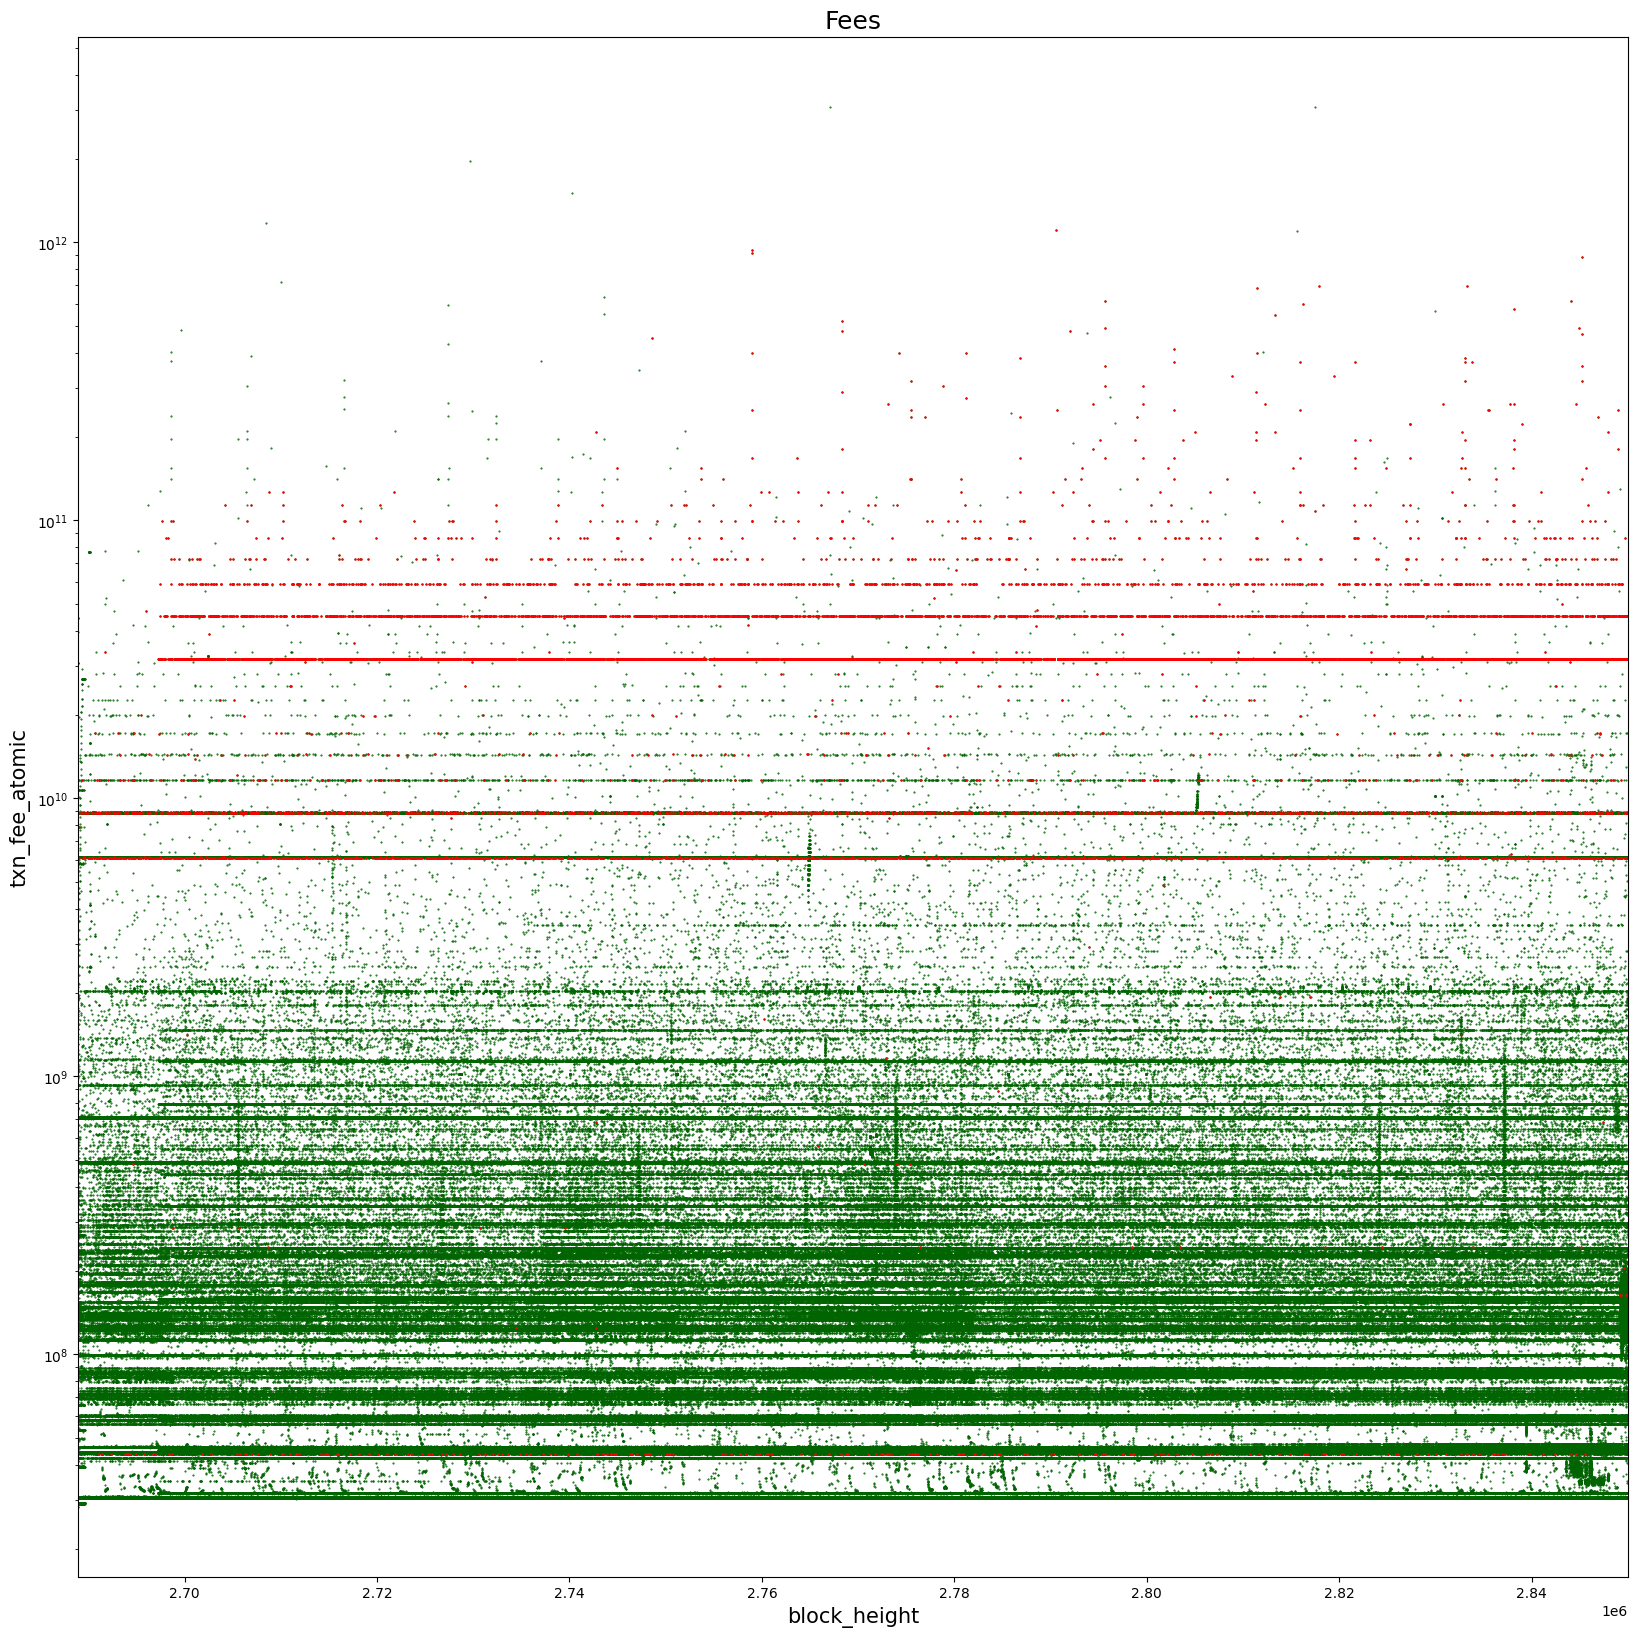

In [16]:
for _ in (0, 0):
    v.scatter(
        x='block_height',
        y='txn_fee_atomic',
        title=f"Fees",
        markersize=0.25,
        figsize=(20,20),
        log_axes='y',
    )
plt.scatter(
    v.data[v.data['is_in_ymxb_fees']].block_height.tolist(),
    v.data[v.data['is_in_ymxb_fees']].txn_fee_atomic.tolist(),
    color='r',
    s=0.5,
)
print(len(v.data[v.data['is_in_ymxb_fees']]))

## Transaction extra length

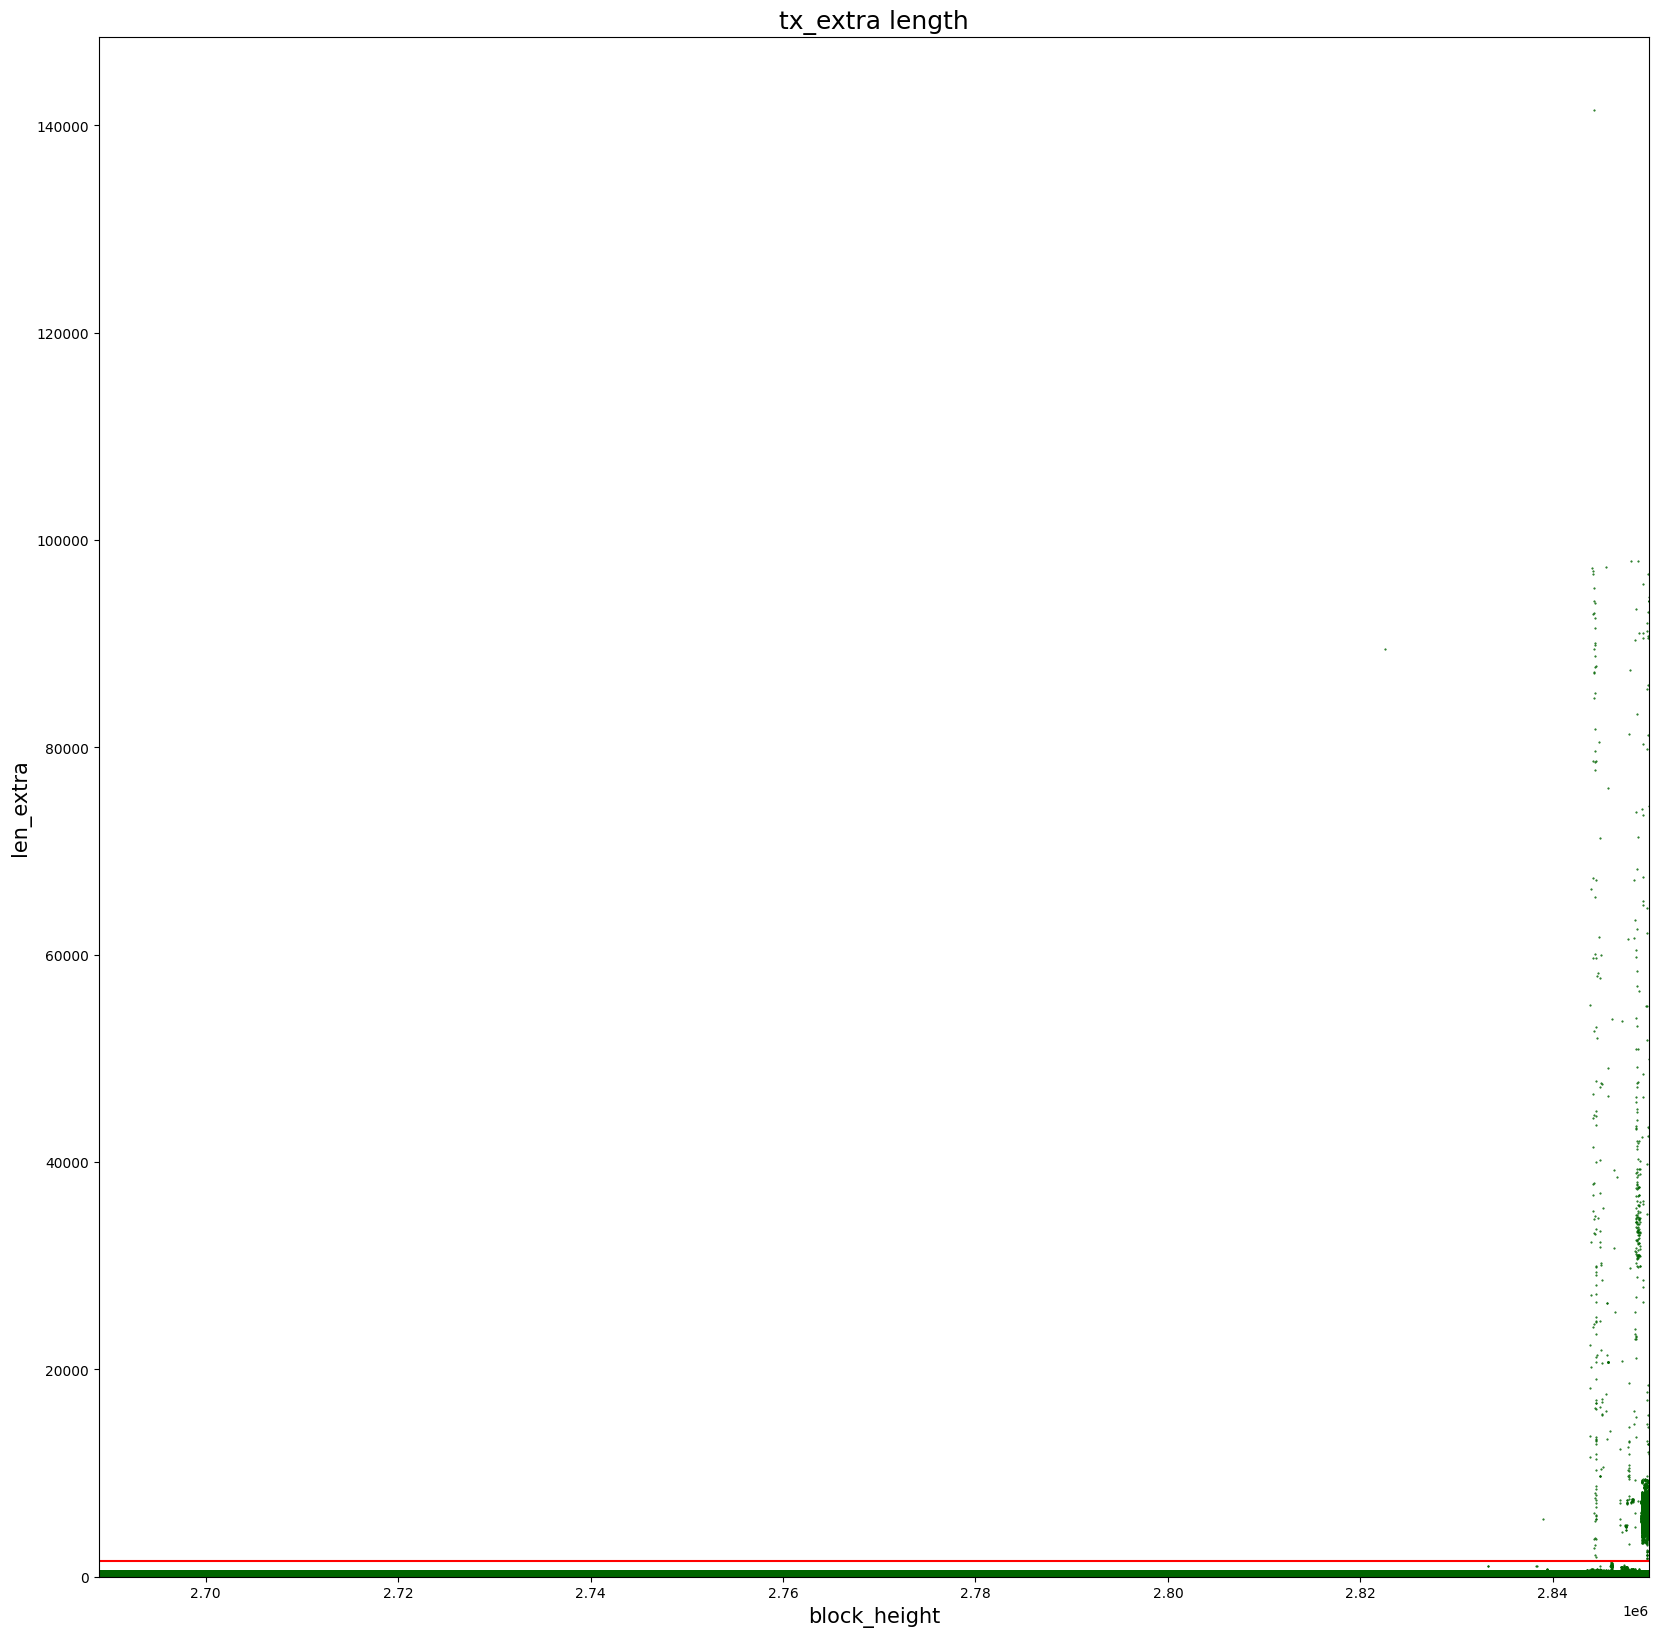

In [19]:
v.scatter(
    x='block_height',
    y='len_extra',
    title="tx_extra length",
    markersize=0.25,
    figsize=(20,20),
    ylim = (0, None),
)
plt.axhline(y=1500, color='r');